# Прокрустово преобразование

### Условие задачи

**Дано:**
- 5 датасетов: `tiny`, `small`, `medium`, `large`, `xlarge`
- каждый датасет содержит массив фигур (кривых) в трехмерном пространстве
- каждая фигура состоит из 1000 точек
- прокрустово преобразование
- метод главных компонент [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- метод [кластеризации](https://scikit-learn.org/stable/modules/clustering.html), например, [`k-средних`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html)

**Требуется:**
- выполнить описанные ниже требования для каждого датасета
- для каждой пары фигур выполнить прокрустово преобразование и вычислить расстояние между кривыми
    - расстояние между кривыми = среднее евклидово расстояние между соответствующими точками фигур (т.е. точками с одинаковыми индексами)
- во время выполнения расчетов выводить время, затраченное на них
- построить матрицу расстояний между кривыми, где в i-й строке (и столбце) расположен вектор расстояний от i-й кривой до всех остальных
- сохранить матрицу расстояний в файл
- к матрице расстояний применить метод главных компонент (`PCA`):
    - выделить 2 главных направления (компоненты), метод `fit`
    - спроецировать векторы расстояний на плоскость, заданную найденными направлениями, метод `transform`
    - на выходе будут получена матрица из двумерных векторов (`проекция`)
    - методы класса `PCA`: `fit` + `transform` или `fit_transform`
- полученную `проекцию` отобразить на рисунке (график 1)
- по графику 1 определить количество кластеров (визуально), если это требует выбранный метод кластеризации
- применить метод кластеризации к векторам `проекции`:
    - определить номер кластера для каждого вектора `проекции`, а, следовательно, для каждой фигуры
    - определить центры кластеров
- отобразить `проекцию`, центры и номера кластеров (график 2)
- для каждого кластера построить рисунок (графики 3):
    - три проекции фигур этого кластера (`x-y`, `x-z`, `y-z`)
    - фигуры отображать полупрозрачным цветом
    - см. Рис. 1
- задокументировать функции

<center>
<img src="procrustus_cluster_example.png" width=800 />
    Рис. 1. Пример рисунка с проекциями фигур (график 3)
</center>


**Материалы:**
- [Прокрустов анализ](https://en.wikipedia.org/wiki/Procrustes_analysis)
- [Прокрустово преобразование](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem)
- [Метод главных компонент](https://ru.wikipedia.org/wiki/Метод_главных_компонент)
- [Методы кластеризации](https://scikit-learn.org/stable/modules/clustering.html)
- [Метод k-средних](https://ru.wikipedia.org/wiki/Метод_k-средних)


**Рекомендации:**
- распараллеливать расчеты при помощи `joblib.Parallel` с параметром `prefer = 'processes'`
- использовать аргумент `mmap_mode = 'r'` при загрузке датасетов функцией `np.load` во избежание избыточного потребления памяти (важно для датасета `xlarge`)

**Правила оценивания:**

- оценка за корректно выполненный расчет для каждого датасета, баллов из 100:
```
    dataset    =  tiny, small, medium, large, xlarge
    g(dataset) =   1.0,   3.7,   10.2,  25.1,   60.0
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не сохранена матрица расстояний в файл - 20
    - не построен график 1 - 20
    - не построен график 2 - 20
    - не построен график 3 - 30
    - нет документации функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{dataset=tiny}^{xlarge}{g(dataset)} - \sum_{i}{p(i)}$


In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS, Birch
from numba import jit

@jit(fastmath=True, parallel=True)
def normalize(data):
    centred = data - data.mean(axis=0)
    scaled = centred / np.sqrt(np.mean(centred**2, axis=0))
    return scaled

@jit(fastmath=True, parallel=True)
def procrustes(a, b):
    u, _, vh = np.linalg.svd(a.T @ b)
    r = u @ vh
    return b @ r.T

@jit(fastmath=True, parallel=True)
def get_distance(a, b):
    return np.linalg.norm(a - b, axis=1).mean()

@jit(fastmath=True, parallel=True)
def get_distances_matrix(data, filename):
    n = len(data)
    distances = np.zeros((n, n), dtype=float)
    normed = np.apply_along_axis(normalize, 1, data)

    for i in trange(n, leave=False):
        for j in range(i+1, n):
            distances[i, j] = distances[j, i] = get_distance(normed[i], procrustes(normed[i], normed[j]))

    np.save(filename, distances)


In [34]:
files = [
    'procrustus_problem_dataset_tiny.npy',
    'procrustus_problem_dataset_small.npy',
    'procrustus_problem_dataset_medium.npy',
    # 'procrustus_problem_dataset_large.npy',
    # 'procrustus_problem_dataset_xlarge.npy',
]

In [3]:
for file in files:
    print(f'processing of {file}')
    dataset = np.load(file, mmap_mode='r')
    %time get_distances_matrix(dataset, f'processed_{file}')
    print()

processing of procrustus_problem_dataset_tiny.npy
Wall time: 3.85 s



C:\Users\n8917\AppData\Local\Temp/ipykernel_18412/1558440637.py:24: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_distances_matrix" failed type inference due to: Untyped global name 'trange': Cannot determine Numba type of <class 'function'>

File "..\..\..\AppData\Local\Temp\ipykernel_18412\1558440637.py", line 30:
<source missing, REPL/exec in use?>

  @jit(fastmath=True, parallel=True)
C:\Users\n8917\AppData\Local\Temp/ipykernel_18412/1558440637.py:24: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_distances_matrix" failed type inference due to: Untyped global name 'trange': Cannot determine Numba type of <class 'function'>

File "..\..\..\AppData\Local\Temp\ipykernel_18412\1558440637.py", line 30:
<source missing, REPL/exec in use?>

  @jit(fastmath=True, parallel=True)
C:\Users\n8917\PycharmProjects\cp-python\project_env\lib\site-packages\numba\core\object_mode_p

In [36]:
def get_clusters_by_pca(data, processed_data, name):
    projected = PCA(n_components=2).fit_transform(processed_data)
    plt.figure(figsize=(10,10))
    plt.suptitle(name.split('.')[0].replace('_', ' ').capitalize())
    plt.subplot(221)
    plt.title('График 1')
    plt.scatter(projected[:, 0], projected[:, 1])

    clustered = DBSCAN(min_samples=0.1).fit(projected)
    n_clusters = len(set(clustered.labels_))
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, n_clusters)]

    plt.subplot(222)
    plt.title('График 2')
    for i, cl in enumerate(set(clustered.labels_)):
        cluster = clustered.labels_ == cl
        plt.scatter(projected[cluster, 0], projected[cluster, 1], color=colors[i])
        plt.scatter(projected[cluster, 0].mean(), projected[cluster, 1].mean(), color='red', s=2, marker='+')
        plt.annotate(f'Кластер {i}', (projected[cluster, 0].mean(), projected[cluster, 1].mean()), fontsize=12)

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle('Графики 3')

    for i in range(len(clustered.labels_)):
        for j, k, m in [(0, 0, 1), (1, 0, 2), (2, 1, 2)]:
            axs[j].plot(data[i, :, k], data[i, :, m], c=colors[clustered.labels_[i]], alpha=0.2)
    plt.show()

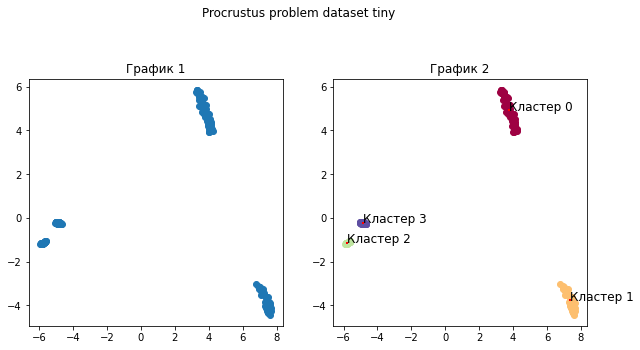

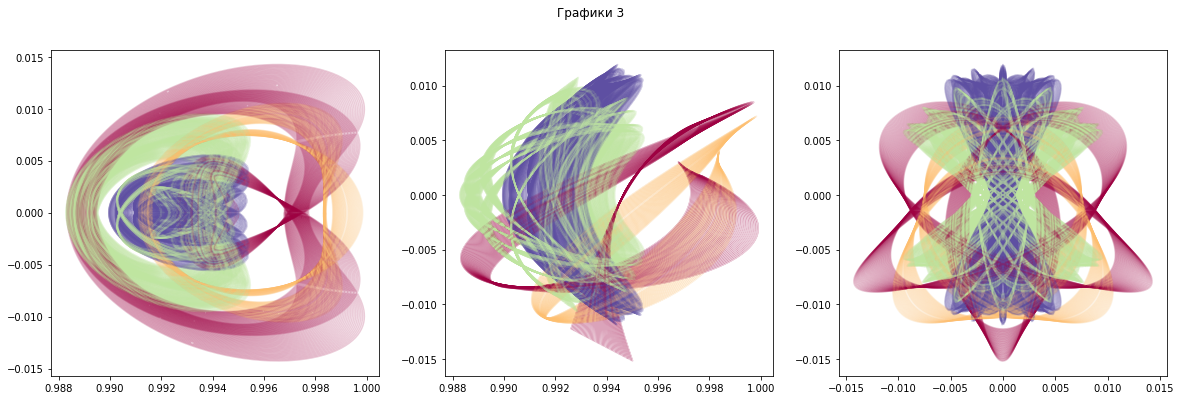

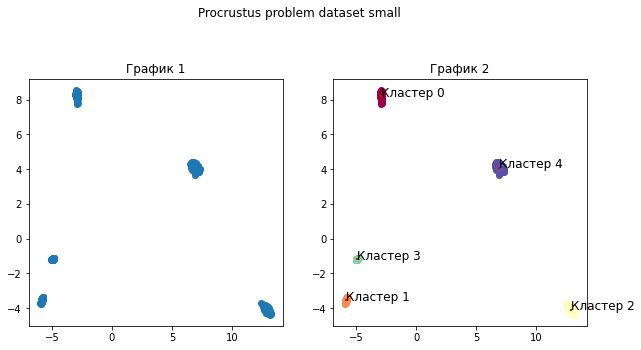

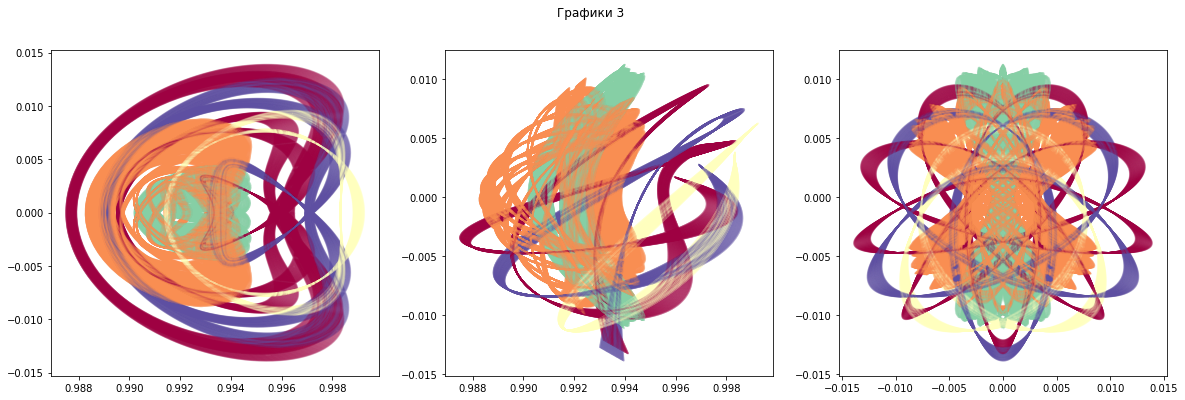

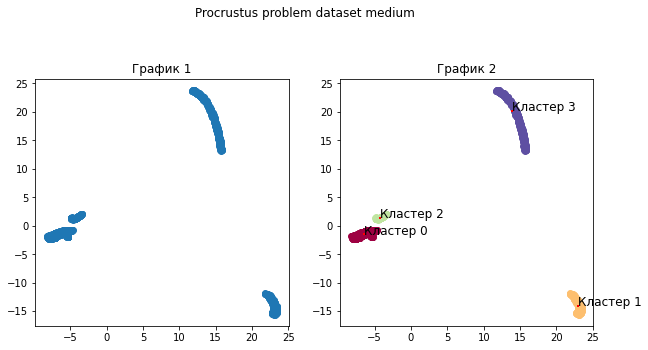

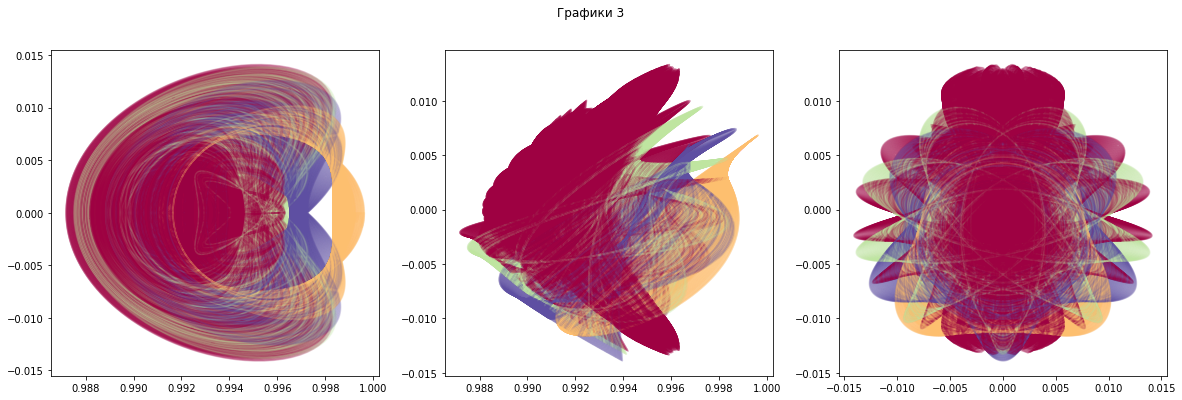

In [37]:
for file in files:
    dataset = np.load(file, mmap_mode='r')
    saved_data = np.load(f'processed_{file}', mmap_mode='r')
    cluster_idx = get_clusters_by_pca(dataset, saved_data, file)